### 1. Overview & data choice for healthy vs aged classification

For this notebook I originally planned to use the **NASA PCoE Li-ion Battery Aging Datasets**  
(<https://data.nasa.gov/dataset/li-ion-battery-aging-datasets>), which contain full aging
trajectories down to clear **end-of-life (EoL)** and are widely used for **SoH / RUL**
studies. At the time of this work I could not access that dataset, so I instead reuse the
SoH-from-EIS dataset from  
[**02 – SoH from EIS (Rashid et al.)**](./02_SoH_from_EIS.ipynb) as a **stand-in** to
demonstrate a simple healthy vs aged **classification workflow**.

In real applications, a cell is typically considered to have reached EoL when its capacity
(or SoH) drops to around **80%** of nominal. The Rashid SoH-from-EIS dataset I use here
only covers SoH levels from **100% down to 80%** in 5% steps, and does **not** include
cells degraded below 80% like the NASA PCoE data would. To still illustrate a binary
screening task with the data at hand, I define:

- `healthy` = SoH ≥ 90%  
- `aged`    = SoH < 90%

This threshold is therefore **chosen for demonstration**, not as a universal definition
of EoL, and should be interpreted as “early screening for cells that have started to age”
rather than a hard safety or warranty limit. In practice, I would expect cells aged
**below 80% SoH to develop a noticeably different impedance fingerprint/signature** from
the SoH ranges considered here (SoH ≥ 90% and SoH < 90%), which could **substantially
change** both the models and the conclusions. The current notebook should therefore be
read as a **workflow demonstration** under limited data, not as a definitive analysis of
fully aged cells.

---

### 2. Dataset and feature pipeline (from 02 – SoH from EIS)

As in  
[**02 – SoH from EIS (Rashid et al.)**](./02_SoH_from_EIS.ipynb), I use the public dataset:

> Rashid, Muhammad; Faraji-Niri, Mona; Sansom, Jonathan; Sheikh, Muhammad;  
> Widanage, Dhammika; Marco, James (2023),  
> **“Dataset for rapid state of health estimation of lithium batteries using EIS and machine learning: Training and validation”**,  
> *Data in Brief*, 48, 109157, doi: 10.1016/j.dib.2023.109157.  
> Original data: **“DIB_Data”**, Mendeley Data, V3, doi: 10.17632/mn9fb7xdx6.3 (CC0 1.0).

Dataset highlights (same as in 02 – SoH from EIS):

- **25 cylindrical Li-ion cells**, aged from SoH 100% down to 80% in 5% steps  
  (100, 95, 90, 85, 80%).
- At each SoH stage, reference performance tests (capacity / SoH) plus **electrochemical
  impedance spectroscopy (EIS)** at multiple **SOC** and **temperature** conditions.
- Designed specifically to study **fast SoH estimation from EIS with machine learning**.

In this notebook I **reuse the same data loading, cleaning and feature engineering
pipeline** as in 02 – SoH from EIS:

- I load the raw EIS spectra and associated metadata,
- perform the same basic QC and filtering,
- and construct the same engineered impedance feature table (ohmic / low-frequency
  resistances, summary |Z| and phase statistics, and sampled spectral points).

For details of the data preparation steps, please refer to  
[**02 – SoH from EIS (Rashid et al.)**](./02_SoH_from_EIS.ipynb). Here I start directly
from the prepared feature table and focus on the **binary classification** of `healthy`
vs `aged` cells based on those impedance features.


### 2.1 Load EIS data

In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd

# Deterministically add ../ (repo root) so that ../src is on the module path
repo_root = Path("..").resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from src.utils import load_and_process_dib_eis, build_impedance_feature_table

# Load long-format EIS data
eis_long_df = load_and_process_dib_eis()

# One row per unique EIS test (cell, SoH, T, SOC)
tests_df = (
    eis_long_df
    .groupby(["cell_id", "soh_pct", "temp_c", "soc_pct"], as_index=False)
    .agg(
        n_points=("frequency_hz", "size"),
        n_freq=("frequency_hz", "nunique"),
    )
)

n_cells = tests_df["cell_id"].nunique()
n_tests = len(tests_df)

soh_levels = sorted(tests_df["soh_pct"].unique())
soc_levels = sorted(tests_df["soc_pct"].unique())
temp_levels = sorted(tests_df["temp_c"].unique())

if tests_df["n_freq"].nunique() == 1:
    freq_points_per_spectrum = int(tests_df["n_freq"].iloc[0])
else:
    freq_points_per_spectrum = f"{tests_df['n_freq'].min()}–{tests_df['n_freq'].max()}"

summary_table = pd.DataFrame(
    {
        "n_cells": [n_cells],
        "n_eis_tests": [n_tests],
        "soh_levels": [", ".join(str(x) for x in soh_levels)],
        "soc_levels": [", ".join(str(x) for x in soc_levels)],
        "temp_levels": [", ".join(str(x) for x in temp_levels)],
        "freq_points_per_spectrum": [freq_points_per_spectrum],
    }
)

summary_table

,n_cells,n_eis_tests,soh_levels,soc_levels,temp_levels,freq_points_per_spectrum
0,24,360,"80, 85, 90, 95, 100","5, 20, 50, 70, 95","15, 25, 35",61


### 2.2 Build the impedance feature table for ML


In [2]:
# Build the engineered impedance feature table (one row per EIS test)
features_df = build_impedance_feature_table(eis_long_df)

print(f"Feature table shape: {features_df.shape}")
features_df.head()


Feature table shape: (360, 27)


,cell_id,soh_pct,temp_c,soc_pct,R_hf_ohm,R_lf_ohm,delta_R_ohm,Zmag_mean,Zmag_std,Zmag_min,...,Zmag_f1p0,phase_f1p0,Zmag_f10p0,phase_f10p0,Zmag_f100p0,phase_f100p0,Zmag_f1000p0,phase_f1000p0,Zmag_f10000p0,phase_f10000p0
0,2,95,15,5,0.02995,0.07366,0.04371,0.040826,0.016416,0.024201,...,0.042847,-0.282403,0.031430,-0.123542,0.027523,-0.077613,0.024205,0.097449,0.043538,0.812199
1,2,95,15,20,0.03001,0.07916,0.04915,0.041919,0.018060,0.024285,...,0.042731,-0.290515,0.031688,-0.122719,0.027668,-0.079707,0.024291,0.095818,0.043579,0.811200
2,2,95,15,50,0.02965,0.03573,0.00608,0.029907,0.003850,0.023819,...,0.030956,-0.031686,0.029673,-0.047501,0.026807,-0.059273,0.023819,0.103972,0.043398,0.818643
3,2,95,15,70,0.02960,0.03803,0.00843,0.030187,0.004274,0.023747,...,0.030942,-0.037886,0.029639,-0.051610,0.026685,-0.058380,0.023747,0.103440,0.043320,0.818540
4,2,95,15,95,0.02958,0.04171,0.01213,0.031920,0.005565,0.023771,...,0.034760,-0.067860,0.030048,-0.092483,0.026772,-0.062605,0.023772,0.101259,0.043262,0.817930


## 3. SoH-based labels for healthy vs aged classification

In this section I convert the SoH information into a **binary health label** that will be
used as the target for the classifier:

- `healthy` = SoH ≥ 90%  
- `aged`    = SoH < 90%

I first add a continuous SoH fraction (`soh_frac`) and then derive the binary
`health_label` (and a numeric `target_aged` = 1 for aged, 0 for healthy). I also inspect
the resulting **class balance** (counts and percentages) to see how many samples fall
into each group before training any models.


### 3.1 Define SoH-based binary labels

In [3]:
# Work on a copy to keep the original feature table intact
data = features_df.copy()

# SoH as fraction (0–1), derived from the integer percentage
data["soh_frac"] = data["soh_pct"] / 100.0

# Binary labels:
# - healthy = SoH ≥ 90%
# - aged    = SoH < 90%
data["health_label"] = np.where(data["soh_pct"] >= 90, "healthy", "aged")

# (Optional) numeric target for later ML models: 1 = aged, 0 = healthy
data["target_aged"] = (data["health_label"] == "aged").astype(int)

data[["cell_id", "soh_pct", "temp_c", "soc_pct", "health_label"]].head()


,cell_id,soh_pct,temp_c,soc_pct,health_label
0,2,95,15,5,healthy
1,2,95,15,20,healthy
2,2,95,15,50,healthy
3,2,95,15,70,healthy
4,2,95,15,95,healthy


### 3.2 Inspect healthy vs aged class balance


In [4]:
# Count samples per class
label_counts = (
    data["health_label"]
    .value_counts()
    .rename_axis("health_label")
    .reset_index(name="n_samples")
)

# Add percentages
total = label_counts["n_samples"].sum()
label_counts["pct"] = (label_counts["n_samples"] / total * 100).round(1)

label_counts


,health_label,n_samples,pct
0,healthy,210,58.3
1,aged,150,41.7


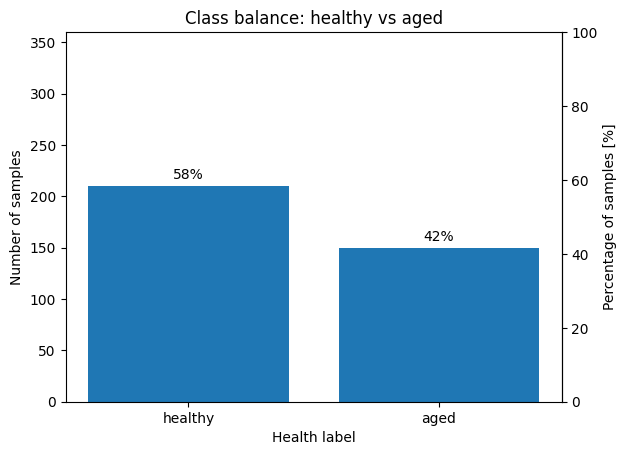

In [5]:
import matplotlib.pyplot as plt

# We already have label_counts with columns: health_label, n_samples, pct
total = label_counts["n_samples"].sum()

fig, ax1 = plt.subplots()

# Primary axis: counts
bars = ax1.bar(label_counts["health_label"], label_counts["n_samples"])
ax1.set_xlabel("Health label")
ax1.set_ylabel("Number of samples")
ax1.set_title("Class balance: healthy vs aged")
ax1.set_ylim(0, total)

# Percentage labels using built-in bar_label
pct_labels = [f"{p:.0f}%" for p in label_counts["pct"]]
ax1.bar_label(bars, labels=pct_labels, padding=3)

# Secondary axis: percentages, linked to counts
def counts_to_pct(c):
    return 100 * c / total

def pct_to_counts(p):
    return total * p / 100

ax2 = ax1.secondary_yaxis("right", functions=(counts_to_pct, pct_to_counts))
ax2.set_ylabel("Percentage of samples [%]")
ax2.set_ylim(0, 100)

plt.show()


## 4. Modelling: nested CV with logistic regression, SVM and GP

In this section I train three **probabilistic classifiers** on the original
engineered impedance features:

1. Regularised logistic regression (`LogisticRegression`)
2. RBF-kernel SVM (`SVC(kernel="rbf", probability=True)`)
3. Gaussian Process Classifier (`GaussianProcessClassifier`)

I use a **nested cross-validation** scheme:

- **Outer loop:** 5-fold grouped splits by `cell_id` to estimate performance
  variability across different groups of cells.
- **Inner loop:** grouped K-fold CV (here 3 folds) on the outer-training data
  for hyperparameter tuning via `GridSearchCV`.

All models are wrapped in `Pipeline`s (with `StandardScaler` where needed) and
evaluated using **ROC AUC** and **PR AUC** on the outer test folds. The results
are collected in a single table for later summary and visualisation.


### 4.1 Features, target and groups

In [6]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from tqdm.auto import tqdm

exclude_cols = [
    "cell_id",
    "soh_pct",
    "soh_frac",
    "health_label",
    "target_aged",
]

feature_cols = [c for c in data.columns if c not in exclude_cols]

X = data[feature_cols].to_numpy()
y = data["target_aged"].to_numpy()
groups = data["cell_id"].to_numpy()

X.shape, y.shape


((360, 25), (360,))

### 4.2 Define models and simple hyperparameter grids

In [7]:
scaler = StandardScaler()

# 1) Logistic regression (baseline)
log_reg_pipe = Pipeline(
    [
        ("scaler", scaler),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="lbfgs",
        )),
    ]
)

log_reg_param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

# 2) RBF SVM
svm_pipe = Pipeline(
    [
        ("scaler", scaler),
        ("clf", SVC(
            kernel="rbf",
            probability=True,
            class_weight="balanced",
            random_state=42,
        )),
    ]
)

svm_param_grid = {
    "clf__C": [0.1, 1.0, 10.0, 100.0],
    "clf__gamma": ["scale", 0.01, 0.1, 1.0],
}

# 3) Gaussian Process Classifier (RBF kernel, fixed hyperparams via CV)
gpc_kernels = [
    RBF(length_scale=0.1, length_scale_bounds="fixed"),
    RBF(length_scale=1.0, length_scale_bounds="fixed"),
    RBF(length_scale=10.0, length_scale_bounds="fixed"),
]

gpc_pipe = Pipeline(
    [
        ("scaler", scaler),
        (
            "clf",
            GaussianProcessClassifier(
                kernel=gpc_kernels[1],  # placeholder; overridden by grid
                optimizer=None,         # no hyperparam optimisation
                random_state=42,
            ),
        ),
    ]
)

gpc_param_grid = {
    "clf__kernel": gpc_kernels,
}

models = {
    "log_reg": log_reg_pipe,
    "svm_rbf": svm_pipe,
    "gp_classifier": gpc_pipe,
}

param_grids = {
    "log_reg": log_reg_param_grid,
    "svm_rbf": svm_param_grid,
    "gp_classifier": gpc_param_grid,
}


### 4.3 Main models training loop

#### 4.3a Define CV objects and inspect outer-fold class balance

In [8]:
# Back to 5 outer / 3 inner folds with shuffling
outer_cv = GroupKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = GroupKFold(n_splits=3, shuffle=True, random_state=42)

# Collect outer-fold class counts
outer_splits = list(outer_cv.split(X, y, groups))
outer_stats = []

for fold, (train_idx, test_idx) in enumerate(outer_splits, start=1):
    y_train, y_test = y[train_idx], y[test_idx]

    train_counts = np.bincount(y_train, minlength=2)
    test_counts = np.bincount(y_test, minlength=2)

    outer_stats.append(
        {
            "outer_fold": fold,
            "train_n": len(y_train),
            "train_neg": int(train_counts[0]),
            "train_pos": int(train_counts[1]),
            "test_n": len(y_test),
            "test_neg": int(test_counts[0]),
            "test_pos": int(test_counts[1]),
        }
    )

outer_stats_df = pd.DataFrame(outer_stats)
outer_stats_df


,outer_fold,train_n,train_neg,train_pos,test_n,test_neg,test_pos
0,1,285,180,105,75,30,45
1,2,285,165,120,75,45,30
2,3,285,165,120,75,45,30
3,4,285,150,135,75,60,15
4,5,300,180,120,60,30,30


#### 4.3b Model training loop (using the same CV objects)

In [9]:
results = []
fold_predictions = []
model_names = list(models.keys())
n_outer = len(outer_splits)  

for model_name in model_names:
    print(f"\n=== Model: {model_name} ===")
    outer_fold = 0

    for outer_train_idx, outer_test_idx in tqdm(
        outer_splits,
        total=n_outer,
        desc=f"{model_name} | outer CV",
    ):
        outer_fold += 1
        print(f"  Outer fold {outer_fold}/{n_outer}")

        X_train, X_test = X[outer_train_idx], X[outer_test_idx]
        y_train, y_test = y[outer_train_idx], y[outer_test_idx]
        groups_train = groups[outer_train_idx]

        base_estimator = models[model_name]
        param_grid = param_grids[model_name]

        gs = GridSearchCV(
            estimator=base_estimator,
            param_grid=param_grid,
            scoring="roc_auc",
            cv=inner_cv,
            n_jobs=-1,
            refit=True,
        )

        # Fit on outer-training data, using groups for inner CV
        gs.fit(X_train, y_train, groups=groups_train)

        best_estimator = gs.best_estimator_
        best_params = gs.best_params_
        best_inner_score = gs.best_score_

        # Evaluate on outer-test data
        y_proba = best_estimator.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        print(
            f"    best inner ROC AUC = {best_inner_score:.3f} | "
            f"outer ROC AUC = {roc_auc:.3f}, PR AUC = {pr_auc:.3f}"
        )

        results.append(
            {
                "outer_fold": outer_fold,
                "model": model_name,
                "roc_auc": roc_auc,
                "pr_auc": pr_auc,
                "best_inner_roc_auc": best_inner_score,
                "best_params": best_params,
                "n_test_samples": len(y_test),
            }
        )

        # store per-fold predictions for later ROC/PR curves
        fold_predictions.append(
            {
                "outer_fold": outer_fold,
                "model": model_name,
                "y_test": y_test,
                "y_proba": y_proba,
            }
        )

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(
    by=["roc_auc", "pr_auc"], ascending=[False, False]
).reset_index(drop=True)

results_df



=== Model: log_reg ===


log_reg | outer CV:   0%|          | 0/5 [00:00<?, ?it/s]

  Outer fold 1/5
    best inner ROC AUC = 0.963 | outer ROC AUC = 0.834, PR AUC = 0.905
  Outer fold 2/5
    best inner ROC AUC = 0.952 | outer ROC AUC = 1.000, PR AUC = 1.000
  Outer fold 3/5
    best inner ROC AUC = 0.962 | outer ROC AUC = 0.996, PR AUC = 0.994
  Outer fold 4/5
    best inner ROC AUC = 0.978 | outer ROC AUC = 0.903, PR AUC = 0.687
  Outer fold 5/5
    best inner ROC AUC = 0.935 | outer ROC AUC = 1.000, PR AUC = 1.000

=== Model: svm_rbf ===


svm_rbf | outer CV:   0%|          | 0/5 [00:00<?, ?it/s]

  Outer fold 1/5
    best inner ROC AUC = 0.964 | outer ROC AUC = 0.689, PR AUC = 0.751
  Outer fold 2/5
    best inner ROC AUC = 0.909 | outer ROC AUC = 1.000, PR AUC = 1.000
  Outer fold 3/5
    best inner ROC AUC = 0.977 | outer ROC AUC = 0.604, PR AUC = 0.695
  Outer fold 4/5
    best inner ROC AUC = 0.996 | outer ROC AUC = 0.899, PR AUC = 0.638
  Outer fold 5/5
    best inner ROC AUC = 0.938 | outer ROC AUC = 1.000, PR AUC = 1.000

=== Model: gp_classifier ===


gp_classifier | outer CV:   0%|          | 0/5 [00:00<?, ?it/s]

  Outer fold 1/5
    best inner ROC AUC = 0.962 | outer ROC AUC = 0.861, PR AUC = 0.908
  Outer fold 2/5
    best inner ROC AUC = 0.941 | outer ROC AUC = 0.997, PR AUC = 0.995
  Outer fold 3/5
    best inner ROC AUC = 0.963 | outer ROC AUC = 0.649, PR AUC = 0.712
  Outer fold 4/5
    best inner ROC AUC = 0.961 | outer ROC AUC = 0.927, PR AUC = 0.730
  Outer fold 5/5
    best inner ROC AUC = 0.933 | outer ROC AUC = 0.946, PR AUC = 0.940


,outer_fold,model,roc_auc,pr_auc,best_inner_roc_auc,best_params,n_test_samples
0,2,log_reg,1.000000,1.000000,0.952222,{'clf__C': 0.1},75
1,5,log_reg,1.000000,1.000000,0.935370,{'clf__C': 0.1},60
2,2,svm_rbf,1.000000,1.000000,0.908593,"{'clf__C': 1.0, 'clf__gamma': 0.01}",75
3,5,svm_rbf,1.000000,1.000000,0.938210,"{'clf__C': 1.0, 'clf__gamma': 0.01}",60
4,2,gp_classifier,0.997037,0.995474,0.940704,{'clf__kernel': RBF(length_scale=10)},75
5,3,log_reg,0.995556,0.993845,0.962296,{'clf__C': 0.1},75
6,5,gp_classifier,0.945556,0.939726,0.933457,{'clf__kernel': RBF(length_scale=1)},60
7,4,gp_classifier,0.926667,0.729529,0.961420,{'clf__kernel': RBF(length_scale=10)},75
8,4,log_reg,0.903333,0.687388,0.978333,{'clf__C': 1.0},75
9,4,svm_rbf,0.899444,0.638067,0.995556,"{'clf__C': 10.0, 'clf__gamma': 0.01}",75


## 5. Results: outer-fold performance

First I summarise the nested CV performance across the 5 outer folds for each
model using boxplots of:

- ROC AUC (aged vs healthy)
- PR AUC (precision–recall for the aged class)

Each point comes from one outer test fold; the boxes show the spread across
folds for each model.


### 5.1 Boxplots of ROC AUC and PR AUC

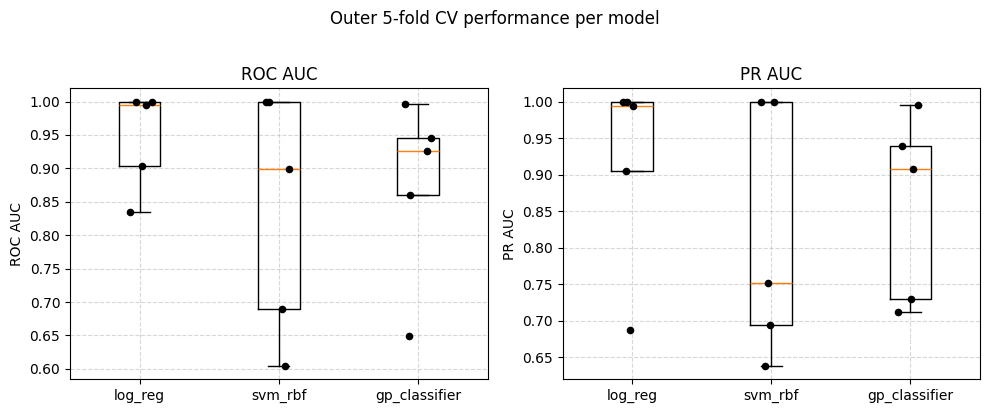

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Consistent model order and pretty labels
model_order = ["log_reg", "svm_rbf", "gp_classifier"]
metric_labels = {"roc_auc": "ROC AUC", "pr_auc": "PR AUC"}

metrics_to_plot = ["roc_auc", "pr_auc"]
rng = np.random.RandomState(42)  # for reproducible jitter

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

for ax, metric_name in zip(axes, metrics_to_plot):
    data = [
        results_df.loc[results_df["model"] == m, metric_name].values
        for m in model_order
    ]

    # Boxplot without default fliers
    ax.boxplot(data, showfliers=False)
    ax.set_xticks(range(1, len(model_order) + 1))
    ax.set_xticklabels(model_order, rotation=0)
    ax.set_title(metric_labels[metric_name])
    ax.set_ylabel(metric_labels[metric_name])

    # Add horizontal grid
    ax.grid(True, linestyle="--", alpha=0.5)

    # Overlay the individual fold values as small jittered black dots
    for i, vals in enumerate(data, start=1):
        x_jitter = i + rng.uniform(-0.1, 0.1, size=len(vals))
        ax.scatter(
            x_jitter,
            vals,
            s=20,
            marker="o",
            color="black",
            zorder=3,
        )

fig.suptitle("Outer 5-fold CV performance per model", y=1.02)
fig.tight_layout()
plt.show()


### 5.2 ROC and precision–recall curves

To visualise the trade-offs, I build ROC and PR curves for each model by
concatenating the predictions from all outer test folds and computing the
curves on these cross-validated predictions.


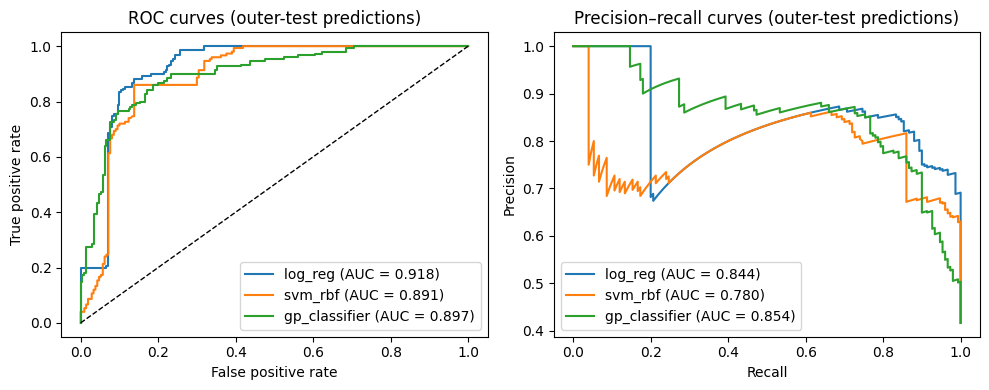

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Aggregate outer-test predictions per model
cv_preds = {}

for m in model_order:
    y_all = []
    p_all = []
    for fp in fold_predictions:
        if fp["model"] == m:
            y_all.append(fp["y_test"])
            p_all.append(fp["y_proba"])
    y_all = np.concatenate(y_all)
    p_all = np.concatenate(p_all)
    cv_preds[m] = {"y": y_all, "proba": p_all}

# Compute curves
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# ROC curves
ax = axes[0]
for m in model_order:
    y_true = cv_preds[m]["y"]
    y_score = cv_preds[m]["proba"]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc_val = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{m} (AUC = {roc_auc_val:.3f})")

ax.plot([0, 1], [0, 1], "k--", linewidth=1)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC curves (outer-test predictions)")
ax.legend()

# PR curves
ax = axes[1]
for m in model_order:
    y_true = cv_preds[m]["y"]
    y_score = cv_preds[m]["proba"]
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc_val = auc(recall, precision)
    ax.plot(recall, precision, label=f"{m} (AUC = {pr_auc_val:.3f})")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–recall curves (outer-test predictions)")
ax.legend()

plt.tight_layout()
plt.show()


### 5.3 Interpretation of healthy vs aged classification results

**Class balance & splits**

- Each outer test fold has **60–75 samples** with both classes present  
  (e.g. test sets range from 30/45 to 60/15 healthy/aged), so ROC and PR
  metrics are well-defined and there is no obvious class-collapse in any fold.

**Overall separability**

- All three models achieve **high ROC AUC (~0.84–0.95 on average)** and
  **PR AUC (~0.82–0.92)** across the 5 outer folds, which means the impedance
  features carry a strong signal for the `healthy` vs `aged` label.
- The pooled ROC/PR curves show that, for a wide range of thresholds, we can
  keep the **false positive rate reasonably low** while maintaining good recall
  for aged cells.

**Model comparison**

- **Logistic regression**
  - Highest and most stable performance: mean ROC AUC ≈ **0.95**, PR AUC ≈ **0.92**
    with relatively small fold-to-fold spread.
  - Several outer folds reach ROC/PR ≈ **1.0**, which suggests that in those
    particular cell splits the classes are almost perfectly linearly separable in
    the chosen feature space.
  - Given its simplicity, this is a very strong baseline and indicates that a
    mostly linear decision boundary in impedance features is already very
    effective for this healthy/aged split.

- **Gaussian Process Classifier**
  - Close runner-up: mean ROC AUC ≈ **0.88**, PR AUC ≈ **0.86**.
  - Shows more variability across folds (one fold drops to ROC AUC ≈ 0.65).

- **RBF SVM**
  - Slightly weaker and more variable: mean ROC AUC ≈ **0.84**, PR AUC ≈ **0.82**,
    with one difficult fold around ROC AUC ≈ 0.60 and others close to 1.0.
  - The higher variance across folds likely reflects sensitivity to the
    hyperparameters and to which cells land in train vs test.

**Caveats**

- The near-perfect scores on some folds are plausible given:
  - relatively small outer test sets (60–75 samples), and
  - a **constructed label** (`SoH ≥ 90%` vs `< 90%`) that may align quite
    cleanly with certain impedance patterns for some cells.
- However, the fact that:
  - the evaluation is **nested**,  
  - splits are grouped by `cell_id`, and  
  - not all folds achieve 1.0,
  suggests we are not seeing a trivial leak, but rather a genuinely
  strong separability in this dataset and threshold choice.

Overall, the results show that impedance-based features in this Rashid et al.
dataset are highly informative for the early **healthy vs aged** screening task,
with **regularised logistic regression** already providing a very competitive
and stable classifier, and SVM / GP offering alternative non-linear and
probabilistic views with slightly lower but comparable performance.


## 6. Feature importance and 2D decision regions

Here I look at **which impedance features matter most** for the healthy vs aged
classification, and how the three classifiers behave in a **2D feature plane**.

- First, I refit each model once on the **full dataset** (using grouped CV on
  `cell_id` for hyperparameter tuning) and compute **permutation importance**,
  using ROC AUC as the scoring metric.
- Then, for each model, I take its **two most important features**, train a
  small 2D version of the classifier on those features, and visualise the
  **decision regions / probability maps** together with the data points.
